In [80]:
import importlib
from pathlib import Path

import numpy as np
import pandas as pd

import config
import module
from tests import test

for p in [config, module,test]:
    try:
        importlib.reload(p)  # reload module
    except NameError:
        pass

# Load DF

In [81]:
# load DFs
df_att = pd.read_excel(config.path_attendance_data)
df_sess = pd.read_excel(config.path_session_data)
df_trainer = pd.read_excel(config.path_trainer_data, sheet_name=config.month)
df_noncoco = pd.read_excel(config.path_noncoco)
df_coco_member = pd.read_excel(config.path_coco_member)
df_erwin_member = pd.read_parquet(config.path_erwin_member)

# Clean and Merge DF

In [82]:
# add data source column to df_sess and df noncoco
# drop index column
# sort column alphabetically
df_sess = (
    df_sess.assign(data_source="coco")
    .drop(columns="index", errors="ignore")
    .loc[:, lambda df_: sorted(df_.columns)]
)
df_noncoco = (
    df_noncoco.assign(data_source="noncoco")
    .drop(columns="index", errors="ignore")
    .loc[:, lambda df_: sorted(df_.columns)]
)

# merge df session and df noncoco
df_sess_full = pd.concat([df_sess, df_noncoco], axis=0)
df_sess_full = (
    df_sess_full.reset_index(drop=True)
    .assign(index=lambda df_: df_.index + 1)
    .assign(
        class_duration=lambda df_: pd.to_numeric(df_["class_duration"], errors="raise"),
        class_grouping=lambda df_: df_["class_type_grouped"].map(module.class_grouping),
    )
)
df_sess_full.shape

(5455, 20)

## Test

In [83]:
test.test_noncoco_online_class_is_online_location(df_noncoco)
test.test_coco_and_noncoco_cols_same(df_sess, df_noncoco)
test.test_class_exist_in_module_class_grouping(df_sess_full)
test.test_teacher_center_area_position_not_null(df_sess_full)
test.test_no_trainer_is_duplicated(df_trainer)

# Sheet 3: Class Session & util

In [84]:
class_session = (
    df_sess_full
    # ! exclude GOC
    .loc[df_sess_full["class_mode"] != "GOC"]
    .groupby(["class_grouping", "class_mode", "class_type_grouped"])
    .agg(
        total_scheduled_session=("index", "nunique"),
        # count how many rows have status "Given"
        total_delivered_session=("class_status", lambda c: (c == "Given").sum()),
        # use sum first because to obtain avg, have to divide sum by num of classes
        total_attendance=("class_attendance", "sum"),
    )
    # assign max attendance per class type
    .assign(
        max_attendance=lambda df_: df_.index.get_level_values(2).map(
            module.class_target
        )
    )
    .astype("Int64")
    .assign(
        avg_attendance=lambda df_: df_["total_attendance"]
        .div(df_["total_delivered_session"])
        .round(1),
        avg_per_max_attendance=lambda df_: df_["avg_attendance"]
        .div(df_["max_attendance"])
        .round(2),
    )
    # sort index top place "Other" below
    .sort_index(level=0, ascending=False)
    .assign(
        percentage_delivered=lambda df_: df_["total_delivered_session"]
        .div(df_["total_scheduled_session"])
        .astype(float)
        .round(2),
    )
    .rename(columns=lambda c: c.replace("_", " ").title())
    .rename_axis(["", "Class Mode", "Class Type Grouped"])
    .loc[
        :,
        [
            "Total Scheduled Session",
            "Total Delivered Session",
            "Percentage Delivered",
            "Max Attendance",
            "Avg Attendance",
            "Avg Per Max Attendance",
        ],
    ]
)

class_session

Total Scheduled Session  \
         Class Mode Class Type Grouped                                      
VIP      Online     Online VPG                                        157   
                    Online One-on-one                                 407   
         Offline    VPG                                                58   
                    One-on-one                                        423   
Standard Online     Online Social Club                                294   
                    Online First Lesson                                78   
                    Online Complementary                              365   
                    Online Community                                   35   
                    Online Advising Session                             3   
         Offline    Social Club                                       365   
                    Member's Party                                      9   
                    First Lesson                                       98   
                    Complementary                                     382   
                    Community                                          76   
                    Chat Hour                                         235   
                    Advising Session                                   46   
Other    Online     Online Proskill First Lesson                        2   
                    Online Proskill                                     7   
                    Online Other                                       33   
                    Online IELTS First Lesson                          10   
                    Online IELTS                                        6   
         Offline    Proskill First Lesson                               3   
                    Proskill                                           12   
                    Other                                             439   
                    Mock Test                                          14   
                    IELTS First Lesson                                  2   
                    IELTS                                              27   

                                                  Total Delivered Session  \
         Class Mode Class Type Grouped                                      
VIP      Online     Online VPG                                        118   
                    Online One-on-one                                 240   
         Offline    VPG                                                55   
                    One-on-one                                        296   
Standard Online     Online Social Club                                292   
                    Online First Lesson                                75   
                    Online Complementary                              361   
                    Online Community                                   34   
                    Online Advising Session                             2   
         Offline    Social Club                                       329   
                    Member's Party                                      9   
                    First Lesson                                       94   
                    Complementary                                     324   
                    Community                                          71   
                    Chat Hour                                         232   
                    Advising Session                                   42   
Other    Online     Online Proskill First Lesson                        2   
                    Online Proskill                                     7   
                    Online Other                                       28   
                    Online IELTS First Lesson                          10   
                    Online IELTS                                        6   
         Offline    Proskill First Lesson    

# Sheet 4: ET Utilization

In [85]:
et_excluded= []

et_util = (
    df_sess_full
    # merge with df trainer to get working days etc
    .merge(df_trainer, how="left", on="teacher")
    # ! exclude et if less than 1 month
    .loc[lambda df_: ~(df_['teacher'].isin(et_excluded))]
    # to calculate class duration for delivered only,
    # create a temp column
    # if given, leave, if not given, 0
    .assign(
        class_duration_delivered=lambda df_: np.where(
            df_["class_status"] == "Given", df_["class_duration"], 0
        )
    )
    .groupby(["teacher_position_y", "teacher_area_x", "teacher"])
    .agg(
        working_days=("teacher_working_days", "mean"),
        total_scheduled_hours=("class_duration", "sum"),
        total_delivered_hours=("class_duration_delivered", "sum"),
    )
    # filter only for ET and coach
    .loc[
        lambda df_: df_.index.get_level_values("teacher_position_y").isin(
            ["ET", "Coach"]
        )
    ]
    .assign(
        working_days=lambda df_: df_["working_days"].astype("Int64"),
        total_scheduled_hours=lambda df_: df_["total_scheduled_hours"].astype(int),
        total_delivered_hours=lambda df_: df_["total_delivered_hours"].astype(int),
        scheduled_hours_per_day=lambda df_: (
            df_["total_scheduled_hours"].div(df_["working_days"]).round(1)
        ),
        delivered_hours_per_day=lambda df_: (
            df_["total_delivered_hours"].div(df_["working_days"]).round(1)
        ),
        max_class_hours=lambda df_: module.create_max_hour_per_trainer(df_),
        scheduled_utilization=lambda df_: df_["scheduled_hours_per_day"]
        .div(df_["max_class_hours"])
        .round(2),
        delivered_utilization=lambda df_: df_["delivered_hours_per_day"]
        .div(df_["max_class_hours"])
        .round(2),
    )
    .rename(columns=lambda c: c.replace("_", " ").title())
    .rename_axis(["Teacher Position", "Teacher Area", "Teacher"])
)
print(et_util.shape)
et_util.head()

(33, 8)


Working Days  \
Teacher Position Teacher Area Teacher                                    
Coach            BDG          Mustikawati Eka                       20   
                 JKT 1        Hamsah Handayani Ratnasari            21   
                              Mordechai Kaleb Arthur                20   
                              Oktavia Cindy                         21   
                              Rifani Aurora Nurhidayah              21   

                                                          Total Scheduled Hours  \
Teacher Position Teacher Area Teacher                                             
Coach            BDG          Mustikawati Eka                               120   
                 JKT 1        Hamsah Handayani Ratnasari                    125   
                              Mordechai Kaleb Arthur                        112   
                              Oktavia Cindy                                 106   
                              Rifani Aurora Nurhidayah                      114   

                                                          Total Delivered Hours  \
Teacher Position Teacher Area Teacher                                             
Coach            BDG          Mustikawati Eka                               103   
                 JKT 1        Hamsah Handayani Ratnasari                    112   
                              Mordechai Kaleb Arthur                         90   
                              Oktavia Cindy                                  72   
                              Rifani Aurora Nurhidayah                       89   

                                                          Scheduled Hours Per Day  \
Teacher Position Teacher Area Teacher                                               
Coach            BDG          Mustikawati Eka                                 6.0   
                 JKT 1        Hamsah Handayani Ratnasari                      6.0   
                              Mordechai Kaleb Arthur                          5.6   
                              Oktavia Cindy                                   5.0   
                              Rifani Aurora Nurhidayah                        5.4   

                                                          Delivered Hours Per Day  \
Teacher Position Teacher Area Teacher                                               
Coach            BDG          Mustikawati Eka                                 5.2   
                 JKT 1        Hamsah Handayani Ratnasari                      5.3   
                              Mordechai Kaleb Arthur                          4.5   
                              Oktavia Cindy                                   3.4   
                              Rifani Aurora Nurhidayah                        4.2   

                                                          Max Class Hours  \
Teacher Position Teacher Area Teacher                                       
Coach            BDG          Mustikawati Eka                         5.0   
                 JKT 1        Hamsah Handayani Ratnasari              5.0   
                              Mordechai Kaleb Arthur                  5.0   
                              Oktavia Cindy                           5.0   
                              Rifani Aurora Nurhidayah                5.0   

                                                          Scheduled Utilization  \
Teacher Position Teacher Area Teacher                                             
Coach            BDG          Mustikawati Eka                               1.2   
                 JKT 1        Hamsah Handayani Ratnasari                    1.2   
                              Mordechai Kaleb Arthur                       1.12   
                              Oktavia Cindy                                 1.0   
                              Rifani Aurora Nurhidayah                     1.08   

                                                          Del

# Sheet 5: Ooolab

In [86]:
ooolab= (df_sess_full
    .loc[df_sess_full['teacher_center'] == 'Ooolab']
    .groupby(['class_service', 'class_mode', 'class_type_grouped', 'class_type'])
    .size()
    .to_frame()
    .rename(columns= {0: 'count'})
    .rename(columns= lambda c: c.replace('_', ' ').title())
    .rename_axis(['Class Service', 'Class Mode', 'Class Type Grouped', 'Class Type'])
)
ooolab

Count
Class Service Class Mode Class Type Grouped   Class Type                  
Deluxe & Go   Online     Online Complementary Online Complementary     116
                         Online Social Club   Online Social Club        99
VIP           Online     Online VPG           Online Complementary       7
                                              Online English Corner     71

# Sheet 6: Community

In [87]:
df_comm = (
    df_sess
    # filter for community
    .loc[df_sess["class_type_grouped"].isin(["Online Community", "Community"])]
    .assign(
        # create com name
        community_name=lambda df_: module.create_com_class(df_["class_description"]),
        # create com class type
        community_class_type=lambda df_: module.create_com_class_type(
            df_["class_description"]
        ),
    )
    .groupby(["community_name", "community_class_type", "class_mode"])
    .agg(
        # get avg attendance
        avg_attendance=("class_attendance", lambda x: x.mean().round(1))
    )
    .reset_index()
    .pivot(columns="community_name", index=["community_class_type", "class_mode"])
    .transpose()
    .rename_axis(["", ""], axis=1)
    .rename_axis(["", ""], axis=1)
    .reset_index()
    .drop(columns="level_0", level=0)
    .rename(columns={"community_name": "Community"})
    # .loc[lambda df_: df_["community_class_type"] == "NONE", "class_description"]
)
df_comm

Community Meet Up        Showcase        Workshop       
             Offline Online  Offline Online  Offline Online
0      CRE-8     6.0   14.0      NaN   13.0      4.9   11.0
1       Leap     7.9   14.0      NaN   22.0      6.3   23.3
2  Re-Charge     7.0   19.8      NaN   31.0      5.3   13.5
3  Syndicate     7.8   16.8     18.0    NaN      6.4   17.2

In [88]:
df_comm_full = (
    df_sess
    # filter for community
    .loc[df_sess["class_type_grouped"].isin(["Online Community", "Community"])]
    .assign(
        # create com name
        community_name=lambda df_: module.create_com_class(
            df_["class_description"]
        ),
        # create com class type
        community_class_type=lambda df_: module.create_com_class_type(
            df_["class_description"]
        ),
    )
    .groupby(["community_name", "community_class_type", "class_mode"])
    .agg(
        total_scheduled_session=("community_class_type", "count"),
        total_delivered_session=("class_status", lambda i: (i == "Given").sum()),
        total_attendance=("class_attendance", "sum"),
        avg_attendance=("class_attendance", "mean"),
    )
    .assign(
        avg_attendance=lambda df_: df_["avg_attendance"].round(1),
        percentage_delivered=lambda df_: df_["total_delivered_session"]
        .div(df_["total_scheduled_session"])
        .round(2),
    )[
        [
            "total_scheduled_session",
            "total_delivered_session",
            "percentage_delivered",
            "total_attendance",
            "avg_attendance",
        ]
    ]
    .rename(columns=lambda c: c.replace("_", " ").title())
    .rename_axis(["Community", "Class Type", "Class Mode"])
)
df_comm_full.head()

Total Scheduled Session  \
Community Class Type Class Mode                            
CRE-8     Meet Up    Offline                           9   
                     Online                            4   
          Showcase   Online                            1   
          Workshop   Offline                           9   
                     Online                            4   

                                 Total Delivered Session  \
Community Class Type Class Mode                            
CRE-8     Meet Up    Offline                           9   
                     Online                            4   
          Showcase   Online                            1   
          Workshop   Offline                           8   
                     Online                            4   

                                 Percentage Delivered  Total Attendance  \
Community Class Type Class Mode                                           
CRE-8     Meet Up    Offline                     1.00                54   
                     Online                      1.00                56   
          Showcase   Online                      1.00                13   
          Workshop   Offline                     0.89                44   
                     Online                      1.00                44   

                                 Avg Attendance  
Community Class Type Class Mode                  
CRE-8     Meet Up    Offline                6.0  
                     Online                14.0  
          Showcase   Online                13.0  
          Workshop   Offline                4.9  
                     Online                11.0

# Sheet 7: Member Cohort

## Load DFs

In [89]:
# create a date range from jan 2023 to current month
date_ranges = pd.date_range(
    start="2023-01-01",
    end=(pd.to_datetime(config.month, format="%m %b %Y") + pd.offsets.MonthEnd(0)),
    freq="m",
    inclusive="both",
)

# create a date range from jan 2023 to current month in a readable format
month_ranges = [i.strftime("%m %b %Y").lower() for i in date_ranges]

# list of all att files
att_files = [
    f"{config.path_attendance_data_parent}/{i}/data attendance {i[3:]}.xlsx"
    for i in month_ranges
]

# get all att files and concat
dfs = []
for file in att_files:
    try:
        df = pd.read_excel(
            file, usecols=["student_code", "class_date", "student_attendance"]
        )
        dfs.append(df)
    except FileNotFoundError:
        pass
df_att_all_mo = pd.concat(dfs, ignore_index=True)
print(len(date_ranges), len(dfs))

12 12


## Create Cohort

In [90]:
cohort_start_date = (
    pd.to_datetime(config.month, format="%m %b %Y") 
    - pd.Timedelta(days=330)
    - pd.offsets.MonthBegin(1) # make this the beginning of the month
)
cohort_end_date = (
    pd.to_datetime(config.month, format="%m %b %Y") 
    + pd.offsets.MonthEnd(0)  # make this the end of the month
)
print(
    f"cohort start :{cohort_start_date: '%d %b %Y'}, cohort end :{cohort_end_date: '%d %b %Y'}"
)

cohort start : '01 Jan 2023', cohort end : '31 Dec 2023'


In [91]:
# the date on which the member join
df_member_clean = (
    df_coco_member.rename(columns={"start_date": "date"}).assign(is_first=True)
    # loc date between cohort start and end
    .loc[
        lambda df_: (df_["date"] >= cohort_start_date)
        & (df_["date"] <= cohort_end_date),
        ["student_code", "date", "is_first"],
    ]
)

# attendance of all member
df_att_all_mo_clean = (
    df_att_all_mo.loc[lambda df_: df_["student_attendance"] == "Attend"]  # only attend
    .drop(columns=["student_attendance"])
    .rename(columns={"class_date": "date"})
    # loc attendance between cohort start and end
    .loc[
        lambda df_: (df_["date"] >= cohort_start_date)
        & (df_["date"] <= cohort_end_date)
    ]
    # only include members who are in df_member_clean
    # else, old members who started before that will be in the data
    .loc[lambda df_: df_["student_code"].isin(
        df_member_clean["student_code"].unique()
    )]
)

# concat att and member
df_cohort_raw = (
    pd.concat([df_member_clean, df_att_all_mo_clean])
    # drop the same date
    .sort_values(["is_first", "date"])
    .drop_duplicates(subset=["student_code", "date"], keep="first")
    .drop(columns=["is_first"])
    .assign(date=lambda df_: pd.to_datetime(df_["date"]))
    .rename(columns={
        "student_code": "customer_id", 
        "date": "transaction_date"
    })
)

# note: somehow, there are members who started lesson before contract start
# for now, no time to check
# last time checked, there are 125 members
# which is about 3 percent (negligible)
def get_members_study_before_contract_start():
    return (df_cohort_raw
        .fillna(False)
        .assign(is_first=lambda df_: df_["is_first"].astype(str))
        .groupby(["customer_id", "is_first"])
        ["transaction_date"].min()
        .to_frame()
        .reset_index()
        .pivot(index="customer_id", columns="is_first")
        .reset_index()
        .droplevel(0, axis="columns")
        .loc[
            lambda df_: df_["True"] > df_["False"]
        ]
    )

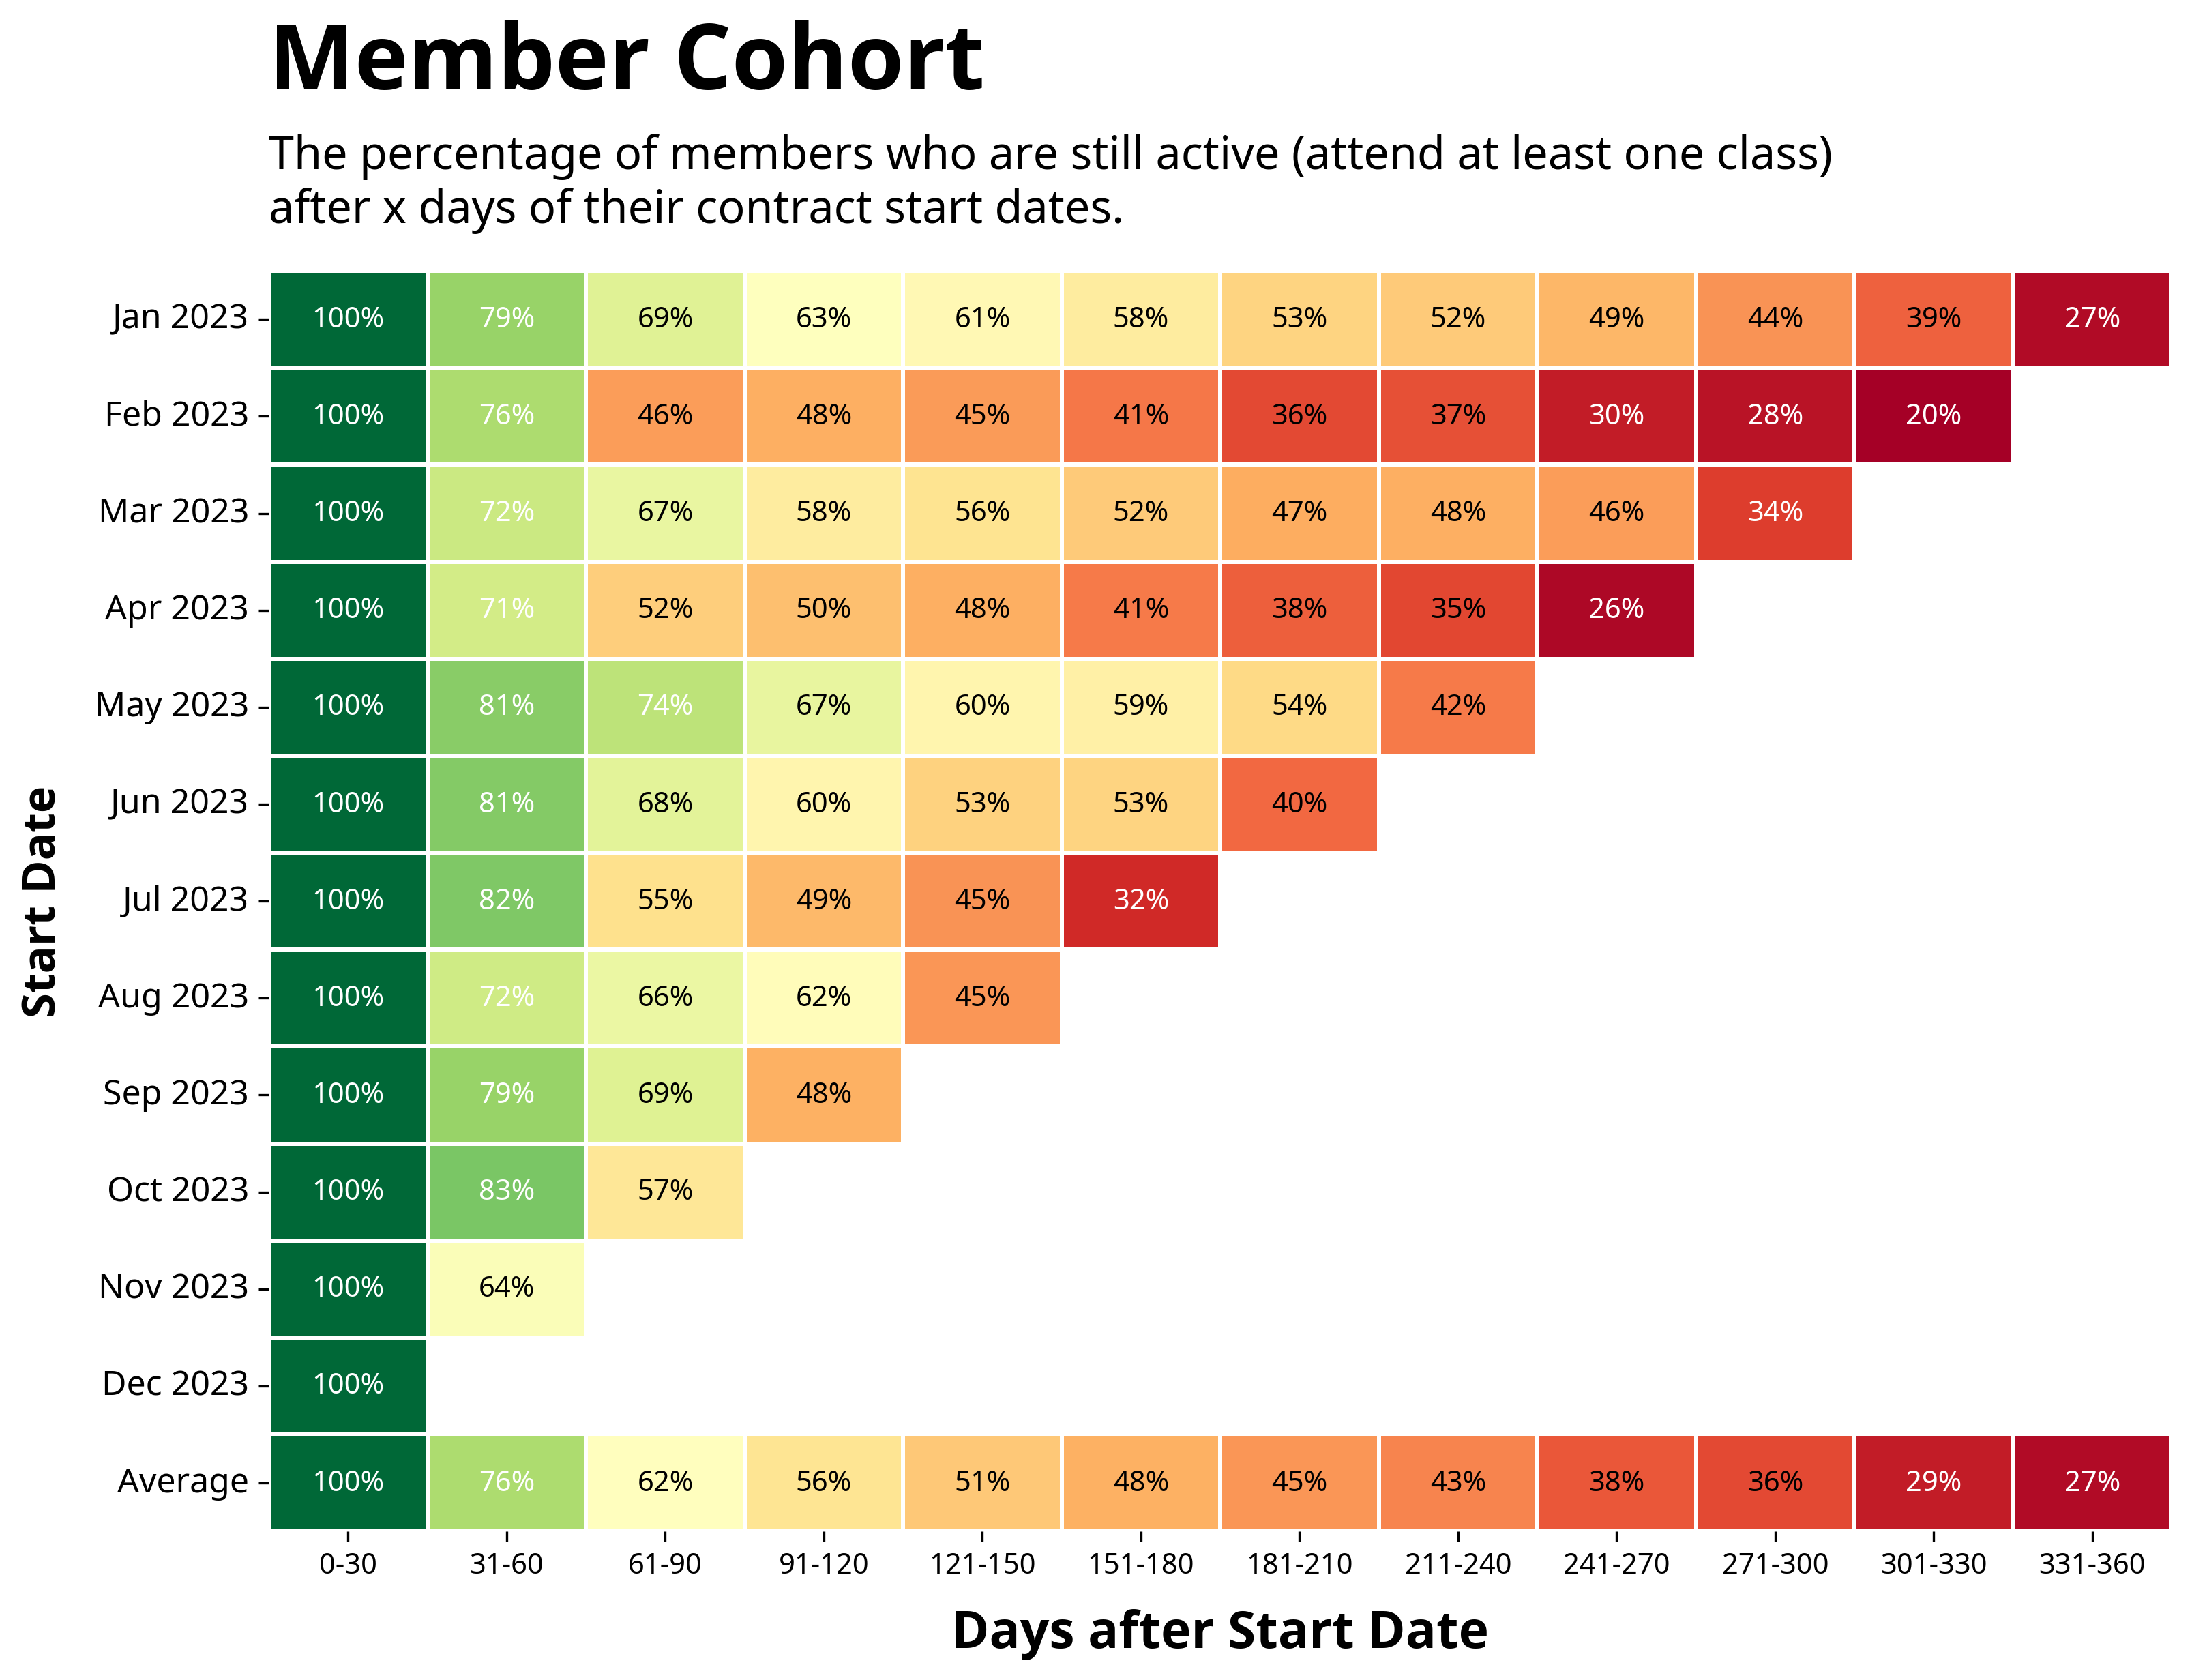

In [92]:
df_cohort = module.make_cohort(df_cohort_raw)
module.plot_cohort(df_cohort)

# Sheet 8: Center Population

## Population based on coco

In [93]:
center_order = pd.CategoricalDtype(config.center_order, ordered=True)

In [94]:
df_coco_pop = (df_coco_member
    .assign(
        # create activity for the current month
        is_active = lambda df_: module.is_active(
            df_, "start_date", "end_date", f"1 {config.month[3:]}"
        ), 
        # get student center and area
        student_center = lambda df_: df_["student_center"].fillna("Not Specified").astype(center_order),
        student_area = lambda df_: df_["student_area"].fillna("Not Specified"),
        consultant = lambda df_: df_["consultant"].str.title(),
    )
    # filter only active student
    .loc[lambda df_: df_["is_active"] == True]
    # group 
    .groupby(["student_area", "student_center", "student_membership"], observed=True)
    .agg(
        num_student=("student_code", "size")
    )
    # pivot
    .reset_index()
    .pivot(
        index=["student_area", "student_center"],
        columns="student_membership"
    )
    .sort_index(axis="rows", level=1)
    .fillna(0)
    .droplevel(0, axis="columns")
    .rename_axis(["Area", "Center"], axis="rows")
    .rename_axis([""], axis="columns")
)
df_coco_pop

Deluxe      GO   VIP
Area          Center                             
JKT 1         PP              510.0     0.0  71.0
              SDC             142.0     0.0   9.0
JKT 2         GC              331.0     0.0  38.0
              LW              125.0     0.0   3.0
              BSD             216.0     0.0  35.0
              TBS               2.0     0.0   1.0
JKT 3         KK              520.0     0.0  59.0
              CBB              96.0     0.0   9.0
BDG           DG              332.0     0.0  12.0
SBY           PKW             103.0     0.0  10.0
Online Center Online Center     0.0  1282.0   0.0
Corporate     Corporate        14.0    25.0   1.0
Not Specified Not Specified     5.0     0.0   0.0

In [95]:
df_coco_pop_activity = (df_coco_member
    .assign(
        # create activity for the current month
        is_active = lambda df_: module.is_active(
            df_, "start_date", "end_date", f"1 {config.month[3:]}"
        ), 
        # get student center and area
        student_center = lambda df_: df_["student_center"].fillna("Not Specified").astype(center_order),
        student_area = lambda df_: df_["student_area"].fillna("Not Specified"),
        is_class_active=lambda df_: np.where(
            df_["student_code"].isin((df_att.loc[df_att["student_attendance"] == "Attend", "student_code"].unique())), 
            "Class Active", "Class Inactive"
        )
    )
    # filter only active student
    .loc[lambda df_: df_["is_active"] == True]
    # group 
    .groupby(["student_area", "student_center", "is_class_active"], observed=True)
    .agg(
        num_student=("student_code", "size")
    )
    # pivot
    .reset_index()
    .pivot(
        index=["student_area", "student_center"],
        columns="is_class_active"
    )
    .sort_index(axis="rows", level=1)
    .fillna(0)
    .droplevel(0, axis="columns")
    .rename_axis(["Area", "Center"], axis="rows")
    .rename_axis([""], axis="columns")
)
df_coco_pop_activity

Class Active  Class Inactive
Area          Center                                     
JKT 1         PP                    270.0           311.0
              SDC                    90.0            61.0
JKT 2         GC                    168.0           201.0
              LW                     50.0            78.0
              BSD                   138.0           113.0
              TBS                     3.0             0.0
JKT 3         KK                    297.0           282.0
              CBB                    55.0            50.0
BDG           DG                    171.0           173.0
SBY           PKW                    56.0            57.0
Online Center Online Center         577.0           705.0
Corporate     Corporate              25.0            15.0
Not Specified Not Specified           1.0             4.0

## Population based on erwin

In [96]:
df_erwin_pop = (df_erwin_member
    # filter only active student and coco student
    .loc[
        (df_erwin_member[f"active_{config.month[3:].replace(' ', '_')}"] == True) &
        ~(df_erwin_member["core_product"].isna())
    ]
    # cast center as categorical for ordering
    .assign(
        center=lambda df_: df_["center"].astype(center_order)
    )
    .groupby(["area","center", "core_product"], observed=True)
    .agg(
        num_student=("center", "count")
    )
    # pivot
    .reset_index()
    .pivot(
        index=["area", "center"],
        columns="core_product"
    )
    .sort_index(axis="rows", level=1)
    .fillna(0)
    .droplevel(0, axis="columns")
    .rename_axis(["Area", "Center"], axis="rows")
    .rename_axis([""], axis="columns")
)
df_erwin_pop

Deluxe      Go   VIP
Area          Center                             
JKT 1         PP              218.0     0.0  38.0
              SDC             101.0     0.0  14.0
JKT 2         GC              210.0     0.0  34.0
              LW               79.0     0.0   1.0
              BSD             220.0     0.0  28.0
              TBS               0.0     0.0   1.0
JKT 3         KK              248.0     0.0  42.0
              CBB              78.0     0.0  11.0
BDG           DG              267.0     0.0  10.0
SBY           PKW              69.0     0.0   8.0
Online Center Online Center     0.0  1310.0   0.0
Corporate     Corporate         6.0    29.0   2.0
Other         HO                3.0     0.0   3.0
              NST            1026.0     0.0  73.0

In [97]:
# TODO: add assertion that no members area, center and membership is na or not specified in config.center_order.sum().sum()

# Data: Class Mapping

In [98]:
df_class_mapping = (
    df_sess_full
    # ! exclude GOC
    .loc[df_sess_full["class_mode"] != "GOC"]
    .assign(
        class_grouping=lambda df_: df_["class_type_grouped"].map(module.class_grouping)
    )
    .groupby(["class_grouping", "class_mode", "class_type_grouped", "class_type"])
    .agg(
        total_scheduled_session=("index", "nunique"),
        # count how many rows have status "Given"
        total_delivered_session=("class_status", lambda c: (c == "Given").sum()),
    )
    .rename_axis(["Class Grouping", "Class Mode", "Class Type Grouped", "Class Type"])
    .rename(columns=lambda c: c.replace("_", " ").title())
)

# Save DF

In [99]:
path= Path.cwd() / f'output/Experience Management Report (Source Code) - {config.month_noncoco}.xlsx'
sheets= [
    'Class Session & Utilization', 
    'ET Utilization',
    'Community Class',
    'Community Class - Full',
    'Ooolab',
    'Member Pop Erwin',
    'Member Pop Coco',
    'Member Pop Coco - Activity',
    'Ooolab',
    'Data - Session',
    'Data - Class Mapping'
]
dfs= [
    class_session, 
    et_util, 
    df_comm, 
    df_comm_full,
    ooolab,
    df_erwin_pop, 
    df_coco_pop, 
    df_coco_pop_activity,
    ooolab.reset_index(),
    df_sess_full,
    df_class_mapping,
]
 
import os
if not os.path.exists(path):
    module.save_multiple_dfs(dfs, sheets, path)
    print('File saved.')
else:
    print('File already exist.')

File saved.


# Experiment

In [100]:
# teachers = [
#     "Lawrence Moore John",
#     "Algar Sinclair Alexander John",
#     "Jane Quinn Madeline",
#     "Handayani Khaerunisyah Risma",
#     "Johanson Brian",
#     "Jurado Michael John",
#     "Phillips Toby",
#     "Oktavia Cindy",
#     "Fairuz Muhammad",
# ]
# for teacher in teachers:
#     result = (df_sess_full
#         .loc[df_sess_full['teacher'] == teacher, ['class_date', 'class_time', 'class_duration']]
#         .drop_duplicates()
#         .assign(class_hour= lambda df_: df_['class_time'].astype(str).str[:2])
#         .groupby('class_date')
#         .agg(
#             class_hour= ('class_hour', lambda x: ', '.join(x)),
#             total_hours= ('class_duration', 'sum')
#         )
#         .loc[lambda df_: df_['total_hours'] <= 6]
#         .reset_index()
#         .assign(
#                 class_date=lambda df_: df_["class_date"].dt.strftime("%d %b"), 
#                 total_hours=lambda df_: df_["total_hours"].astype(int)
#         )
#     )
#     print(teacher)
#     print(result.to_markdown(), end="\n\n")

In [101]:
# # this is the list of members in november or december
# df_member_nov_dec = (df_coco_member
#     .assign(
#         # create activity for the current month
#         is_member_nov = lambda df_: module.is_active(
#             df_, "start_date", "end_date", f"1 nov 2023"
#         ), 
#         is_member_dec = lambda df_: module.is_active(
#             df_, "start_date", "end_date", f"1 dec 2023"
#         ), 
#         # get student center and area
#         student_center = lambda df_: df_["student_center"].fillna("Not Specified").astype(center_order),
#         student_area = lambda df_: df_["student_area"].fillna("Not Specified"),
#     )
#     # get members who are active in nov or dec
#     .loc[lambda df_: 
#          (df_["is_member_nov"] == True) |
#          (df_["is_member_dec"] == True)
#     ]
# )

# df_member_active_nov_dec = (df_att_all_mo
#     .loc[lambda df_: 
#         (df_["class_date"] >= "2023-11-01") & (df_["class_date"] <= "2023-12-31")      
#     ]
#     .loc[
#         lambda df_: df_["student_attendance"] == "Attend"
#     ]
#     .loc[:, "student_code"]
#     .values
# )

# df_member_inactive_nov_dec = (df_member_nov_dec
#     .loc[lambda df_: 
#         ~(df_["student_code"].isin(df_member_active_nov_dec))
#     ]
# )

# filepath = "output/df_member_inactive_nov_dec.xlsx"
# df_member_inactive_nov_dec.to_excel(filepath, index=True)